In [1]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [2]:
"""
code du lightgbm repris (et adapté) de :
Lien : https://www.kaggle.com/code/jsaguiar/lightgbm-7th-place-solution

KAGGLE HOME CREDIT DEFAULT RISK COMPETITION
Adapted from one of the models used in 7th place solution ensemble.
For more details about our solution please check this discussion:
https://www.kaggle.com/c/home-credit-default-risk/discussion/64580

Another similar version is also available at GitHub:
https://github.com/js-aguiar/home-credit-default-competition

This model uses LightGBM with goss and label encode for the application's
categorical features. Other tables are using one-hot encode with mean,
sum and a few different functions to aggregate. The main ideia was to add
more time related features like last application and last X months aggregations.
There are also aggregations for specific loan types and status as well as
ratios between tables. Configurations are in line 785
"""

import os
import numpy as np
import pandas as pd
import cudf
import cuml
import gc
import cupy as cp
from cuml.pipeline import Pipeline

# from cuml.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# import seaborn as sns
import joblib
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb

# from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import pickle
import warnings

from pprint import pprint
from mlflow import MlflowClient

warnings.simplefilter(action="ignore", category=FutureWarning)
## np.warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
# np.seterr(all="ignore", invalid="ignore")

In [3]:
from src.p7_feature_selection import DataSelector
from src.p7_feature_selection import cluster_features
from src.p7_simple_kernel import kfold_lightgbm_simple
from src.p7_simple_kernel import display_importances
from src.p7_full_kernel import display_full_importances
from src.p7_constantes import (
    NUM_THREADS,
    DATA_BASE,
    DATA_INTERIM,
    MODEL_DIR,
    VAL_SEED,
)
from src.p7_missing_values import missing_values_barh
from src.p7_util import timer, reduce_memory_cudf
from src.p7_preprocess import Imputer, VarianceSelector, CuRobustScaler, CuMinMaxScaler
from src.p7_preprocess import balance_nearmiss, balance_smote, get_binary_features
from src.p7_preprocess import ImputerByDtype
from src.p7_explore import plot_default_ratio, corr_sorted_map, corr_cluster_map
from src.p7_feature_selection import get_features_correlated_above, cluster_features
from src.p7_tracking import ExpCorr, ExpPermutation
from src.p7_tracking import delete_experiments_with_prefix, del_studies_from_mlflow, del_artifacts_from_mlflow
from src.p7_hyper_param import SearchLogReg


%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [4]:
print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)

cuDF version: 24.04.01
cuML version: 24.04.00


# Lecture des données de Train

In [5]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v0_built_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 747 entries, SK_ID_CURR to CC_COUNT
dtypes: bool(158), float64(518), int64(71)
memory usage: 1.1 GB


In [6]:
train = reduce_memory_cudf(train)

Memory usage of dataframe is 1086.93 MB
Memory usage after optimization is: 600.40 MB
Decreased by 44.8%


# 1er aperçu

## Colonnes comportant le plus de valeurs manquantes

Taille estimée de figure pour 80 variables : (8, 17.0)


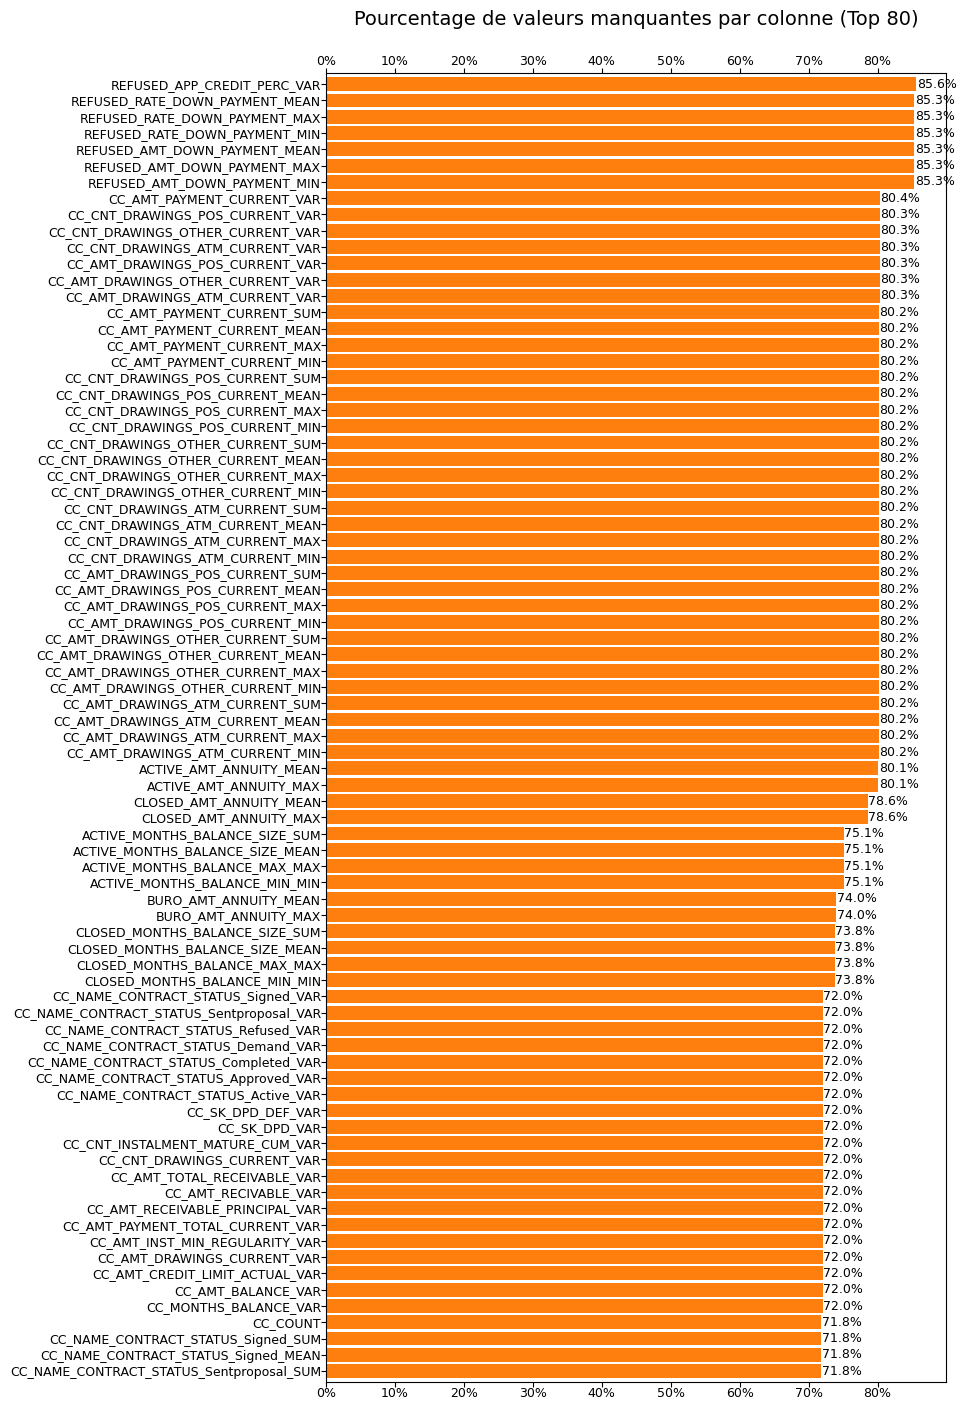

In [7]:
_ = missing_values_barh(train, sort="value", n_max=80, verbose=True)

In [8]:
"""
Ce bref aperçu nous indique qu'il va falloir supprimer des colonnes qui ont trop de valeurs manquantes,
En effet nous n'allons pas imputer sur des colonnes comportant plus de 30% de valeurs manquantes.
Pour éviter de supprimer des features trop importantes, nous allons explorer les features les plus corrélées avec la Target,
et utiliser un premier modèle d'arbres de décision pour estimer les features les plus importantes.
"""

"\nCe bref aperçu nous indique qu'il va falloir supprimer des colonnes qui ont trop de valeurs manquantes,\nEn effet nous n'allons pas imputer sur des colonnes comportant plus de 30% de valeurs manquantes.\nPour éviter de supprimer des features trop importantes, nous allons explorer les features les plus corrélées avec la Target,\net utiliser un premier modèle d'arbres de décision pour estimer les features les plus importantes.\n"

## Proportion de défaut

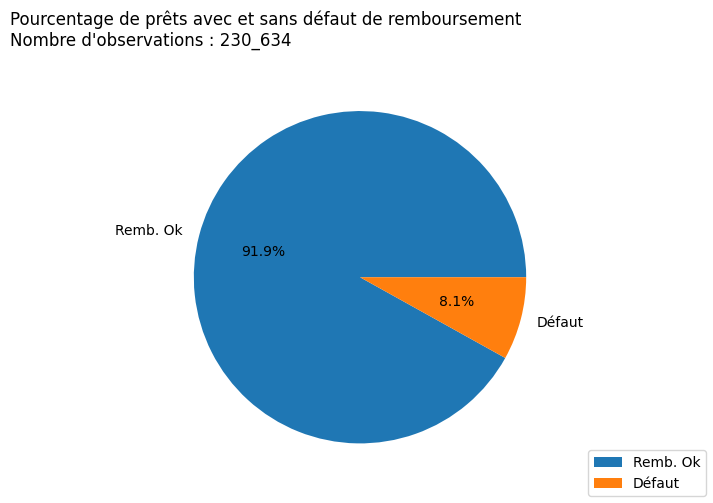

In [9]:
_ = plot_default_ratio(train["TARGET"])

In [10]:
"""
Le dataset étant déséquilibré, il nous faudra en tenir compte dans l'analyse des corrélations
"""

"\nLe dataset étant déséquilibré, il nous faudra en tenir compte dans l'analyse des corrélations\n"

# Valeurs manquantes et importances

## Calcul des importances avec LightGBM API sklearn

In [11]:
"""
Le modèle lightGBM a l'avantage d'accepter les valeurs manquante et d'être relativement rapide.
Nous allons l'utiliser avec des hyperparamètres par défaut (excepté le rééquilibrage), en validation croisée.
"""

"\nLe modèle lightGBM a l'avantage d'accepter les valeurs manquante et d'être relativement rapide.\nNous allons l'utiliser avec des hyperparamètres par défaut (excepté le rééquilibrage), en validation croisée.\n"

### Paramètres par défaut

In [12]:
clf = lgb.LGBMClassifier()
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Predictors, X, y

In [13]:
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = train[predictors].to_pandas()
y = train["TARGET"].to_pandas()
print("Info X :")
print(X.info())
print("\nInfo y :")
print(y.info())

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 745 entries, CODE_GENDER to CC_COUNT
dtypes: bool(158), float32(497), float64(82), int32(6), int64(2)
memory usage: 625.1 MB
None

Info y :
<class 'pandas.core.series.Series'>
RangeIndex: 230634 entries, 0 to 230633
Series name: TARGET
Non-Null Count   Dtype
--------------   -----
230634 non-null  int32
dtypes: int32(1)
memory usage: 901.0 KB
None


### Importances moyennes en validation croisées (dataset rééquilibré par class_weight)

In [14]:
clf = lgb.LGBMClassifier(
    nthread=14,
    class_weight="balanced",
    objective="binary",
    random_state=VAL_SEED,
    # boost_from_average=False, # Sion souhaitait comparer api sklearn et api native,
    verbosity=-1,  # Pour ne pas voir les logs
)
params_lgbm_clf = clf.get_params()
print("Pramètres du cmassifieur LightGBM :")
print(params_lgbm_clf)

folds = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=VAL_SEED,
)
all_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y), start=1):
    X_train, y_train = (
        X.iloc[train_idx],
        y.iloc[train_idx],
    )
    X_val, y_val = (
        X.iloc[valid_idx],
        y.iloc[valid_idx],
    )
    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        # eval_metric="auc",
    )
    # y_score_val = clf.predict(X_val)
    # A chaque fold, on crée un df contenant les importances du fold avec 3 colonnes :
    # 1: nom de la feature, 2 : son importance sur le fold, 3 : le n° du fold
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    # On concatène les df de fold les uns en dessous des autres dans un df qui contient toutes les importances
    all_importance_df = pd.concat([all_importance_df, fold_importance_df], axis=0)

Pramètres du cmassifieur LightGBM :
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': 14, 'verbosity': -1}


## Aggrégations des importances au travers des folds

In [15]:
def mean_importance_from_all_folds(importance_folds, X=None):
    # On calcule la moyenne et l'écart type des importances obtenus sur les folds
    # en les triant de la plus haute importance à la plus basse
    mean_importance = (
        importance_folds.drop("fold", axis=1)
        .groupby("feature")
        .agg(
            importance_mean=("importance", "mean"),
            importance_std=("importance", "std"),
        )
        .sort_values(by="importance_mean", ascending=False)
    )

    # On ajoute une colonne Rank (pour pouvoir trier / détrier dans n'importe quel sens par la suite)
    ranks = range(1, len(mean_importance) + 1)
    mean_importance["rank_importance"] = ranks
    df_res = mean_importance

    # Si X est fourni on ajoute le pourcentage de valeurs manquantes pour chaque feature
    if X is not None:
        missing_df = pd.DataFrame(X.isna().mean() * 100, columns=["missing_pct"])
        df_res = mean_importance.join(missing_df)

    return df_res

In [16]:
mean_importances = mean_importance_from_all_folds(
    importance_folds=all_importance_df, X=X
)
mean_importances.head()

,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
EXT_SOURCE_1,120.4,5.029911,1,56.289185
EXT_SOURCE_2,112.0,3.807887,2,0.208556
CREDIT_TO_ANNUITY_RATIO,99.8,9.257429,3,0.003469
EXT_SOURCE_3,95.4,4.827007,4,19.816679
DAYS_EMPLOYED,63.8,5.805170,5,18.019459


In [17]:
mean_importances.tail()

,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
ORGANIZATION_TYPE_NA,0.0,0.0,741,0.000000
ORGANIZATION_TYPE_Mobile,0.0,0.0,742,0.000000
ORGANIZATION_TYPE_Medicine,0.0,0.0,743,0.000000
ORGANIZATION_TYPE_LegalServices,0.0,0.0,744,0.000000
POS_NAME_CONTRACT_STATUS_Demand_MEAN,0.0,0.0,745,5.825247


## Sauvegarde des importances 01_v0_importances.csv

In [19]:
filepath_importance = os.path.join(DATA_INTERIM, "01_v0_importances.csv")
mean_importances.to_csv(filepath_importance, index=True)
print(f"Importances moyennes enregistrés dans {filepath_importance}")
mean_importances.info()

Importances moyennes enregistrés dans data/interim/01_v0_importances.csv
<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, EXT_SOURCE_1 to POS_NAME_CONTRACT_STATUS_Demand_MEAN
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   importance_mean  745 non-null    float64
 1   importance_std   745 non-null    float64
 2   rank_importance  745 non-null    int64  
 3   missing_pct      745 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 45.3+ KB


## Graphiques

### Graphique global missing et importance 

Avec différence de couleur entre les missign > 30% et les autres

In [215]:
def plot_line_importance_with_missing(
    mean_importances,
    col_importance="importance_mean",
    col_rank="rank_importance",
    col_missing="missing_pct",
):
    threshold_missing = 30
    color_missing_inf30 = "green"
    color_missing_sup30 = "orange"
    color_importance = "blue"

    fig, ax_importance = plt.subplots(figsize=(10, 6))

    # Séparer les points selon le seuil 30% de valeurs manquantes
    below_thresh = mean_importances[mean_importances[col_missing] <= threshold_missing]
    above_thresh = mean_importances[mean_importances[col_missing] > threshold_missing]

    # Axe de gauche : importance
    min_rank_importance = mean_importances[col_rank].min()
    max_rank_importance = mean_importances[col_rank].max()

    ax_importance.set_xlabel(
        f"Rang d'Importance de la Feature ({min_rank_importance} = la + plus importante, {max_rank_importance} = la - importante)"
    )

    ax_importance.set_ylabel("Importance", color=color_importance)
    ax_importance.tick_params(axis="y", labelcolor=color_importance)
    ax_importance.set_ylabel("Importance moyenne (nb splits)")

    # Axe de droite : pourcentage de valeurs manquantes
    ax_missing = ax_importance.twinx()

    ax_missing.set_ylabel("Pourcentage de valeurs manquantes")
    # Définir les ticks personnalisés pour l'axe des % de missing (pour que la grille tombe à des endroits "souhaités")
    missing_custom_ticks = [30, 40, 50, 60, 70, 80, 90]
    ax_missing.set_yticks(missing_custom_ticks)

    # Activer la grille uniquement pour l'axe de droite, avec ces ticks
    ax_missing.yaxis.grid(
        True, which="major", color="lightgrey", linestyle="--", linewidth=0.7
    )

    # On trace la ligne qui représente l'importance
    line_importance = ax_importance.plot(
        mean_importances[col_rank],
        mean_importances[col_importance],
        color=color_importance,
        marker="o",
        markersize=3,
        linewidth=0.7,
        label="Importance",
    )

    # On trace les points < 30% de missing en orange
    line_missing_inf30 = ax_missing.plot(
        below_thresh[col_rank],
        below_thresh[col_missing],
        color=color_missing_inf30,
        marker="o",
        linestyle="None",
        markersize=2,
        label=f"% manquantes ≤ {threshold_missing}%",
    )

    # On trace les points au pourcentage de valeurs manquantes >= 30% en orange
    line_missing_sup30 = ax_missing.plot(
        above_thresh[col_rank],
        above_thresh[col_missing],
        color=color_missing_sup30,
        marker="v",
        linestyle="None",
        markersize=5,
        label=f"% manquantes > {threshold_missing}%",
    )

    # Titre et mise en page
    plt.title("Etude des features : Importance & Valeurs manquantes\n\n\n")

    # Combine les légendes
    lines = line_importance + line_missing_inf30 + line_missing_sup30
    labels = [l.get_label() for l in lines]

    # Légende en dehors du graphique (sinon illisible)
    ax_importance.legend(
        lines,
        labels,
        loc="lower left",  # Position dans la boîte définie par bbox
        bbox_to_anchor=(0.0, 1.02),  # Juste au-dessus du graphique, aligné à gauche
        ncol=3,  # Légende sur une seule ligne
        # frameon=True,
        # framealpha=1.0,
        # facecolor="lightgrey",
        edgecolor="black",
        fontsize=9,
        borderpad=0.8,
    )

    fig.tight_layout()
    plt.grid(True)
    return fig

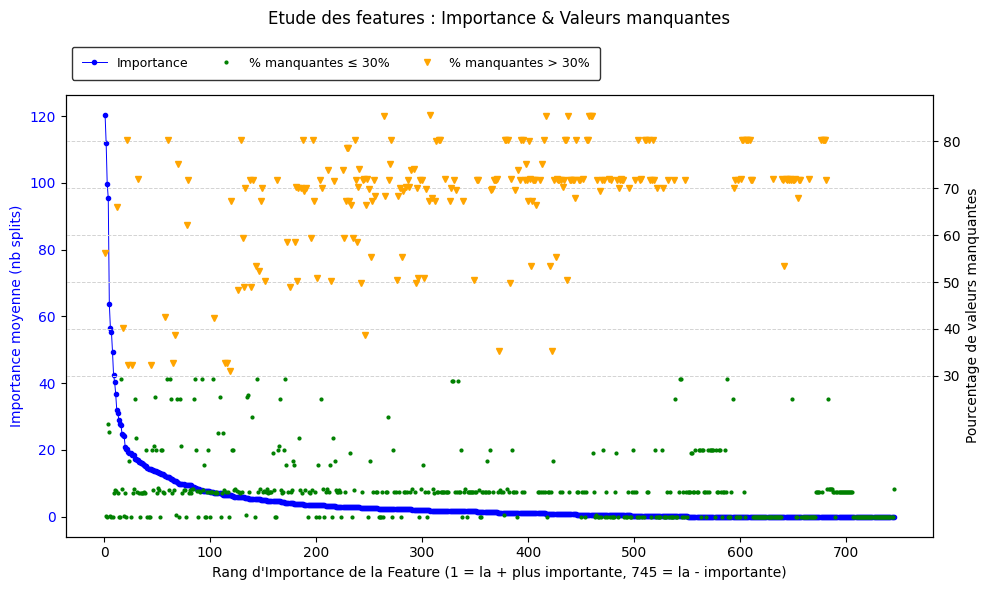

In [216]:
fig_line_importance_with_missing = plot_line_importance_with_missing(mean_importances)

### Graphiques en barres

In [217]:
# Display/plot feature importance
def plot_bar_importances(
    mean_importance,
    col_mean="importance_mean",
    col_std="importance_std",
    top=40,
    sort_by_name=False,
    save_img=False,
):
    best_importance = mean_importance.head(top)
    # Barh inverse l'ordre donc on trie en sens inverse
    if sort_by_name:
        best_importance = best_importance.sort_values(by="feature", ascending=False)
    else:
        best_importance = best_importance.sort_values(by=col_mean, ascending=True)

    # Taille de la figure
    width = 8
    margin = 1
    bar_height = 0.25
    height = margin + bar_height * top

    # print(best_importance)
    fig = plt.figure(figsize=(width, height))
    # Récupère l'axe en cours
    ax = plt.gca()

    barplot = best_importance[col_mean].plot(kind="barh", width=0.85)

    # Récupérer les coordonnées des barres du barplot
    x_positions = [bar.get_width() for bar in barplot.patches]
    y_positions = [bar.get_y() + bar.get_height() / 2 for bar in barplot.patches]

    # Ajouter les barres d'erreur
    plt.errorbar(
        x=x_positions,
        y=y_positions,
        # data=best_importance,
        xerr=[best_importance[col_std], best_importance[col_std]],
        fmt="none",  # Aucun marqueur pour les points de données
        # capsize=5,  # Taille des barres à l'extrémité des lignes d'erreur
        color="black",  # Couleur des barres d'erreur
    )

    fig.suptitle(f"Top {top} des Features les plus importantes par LightGBM\n")
    ax.set(
        ylabel=f"Feature",
        title=f"Titre du graphique",
        xlabel=f"Importance moyenne en nombre de splits",
    )
    # ax.set_title("Titre du graphique", fontsize=10)
    plt.tight_layout()

    return fig

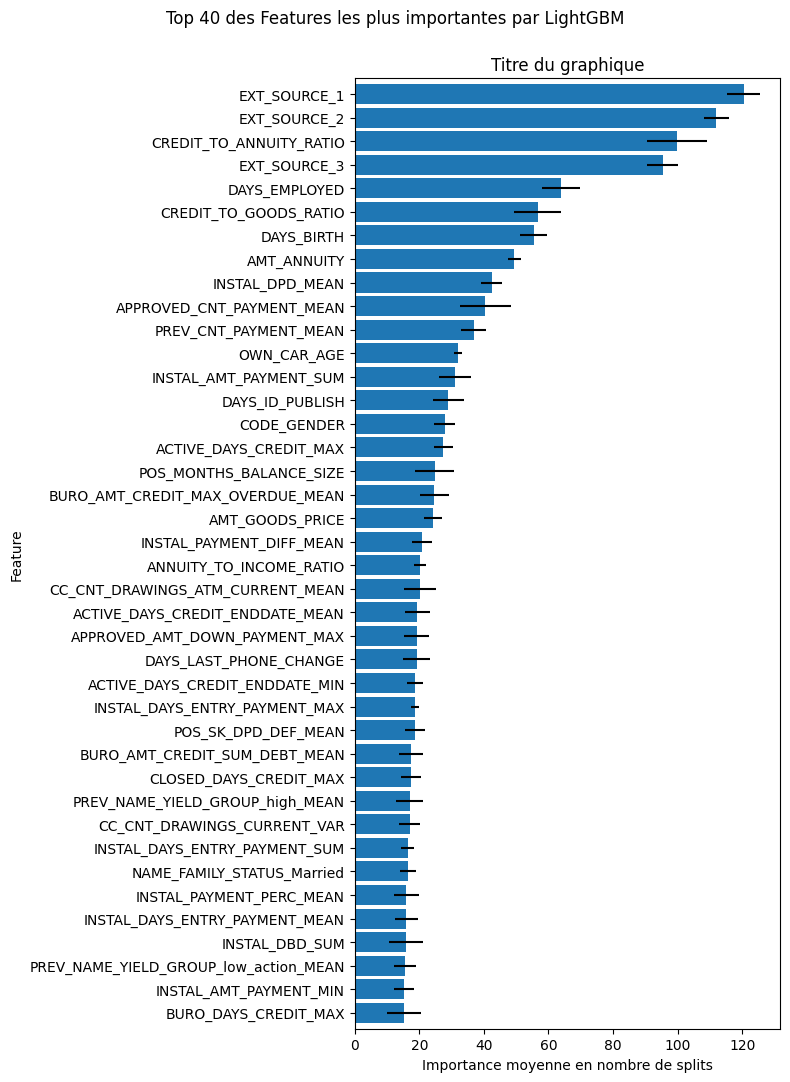

In [218]:
_ = plot_bar_importances(mean_importances)

In [219]:
mean_importances.head()

,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
EXT_SOURCE_1,120.4,5.029911,1,56.289185
EXT_SOURCE_2,112.0,3.807887,2,0.208556
CREDIT_TO_ANNUITY_RATIO,99.8,9.257429,3,0.003469
EXT_SOURCE_3,95.4,4.827007,4,19.816679
DAYS_EMPLOYED,63.8,5.805170,5,18.019459


In [220]:
def plot_bar_importances_with_missing(
    mean_importances,
    col_mean="importance_mean",
    col_std="importance_std",
    col_missing="missing_pct",
    top=40,
    sort_by_name=False,
):
    threshold_missing = 30
    best_importance = mean_importances.sort_values(by=col_mean, ascending=False).head(
        top
    )

    # Trier les données
    if sort_by_name:
        best_importance = best_importance.sort_values(by="feature", ascending=False)
    else:
        best_importance = best_importance.sort_values(by=col_mean, ascending=True)

    # Taille de la figure et sous-graphiques
    width = 10
    margin = 1
    bar_height = 0.25
    height = margin + bar_height * top

    fig, (ax1, ax2) = plt.subplots(
        ncols=2,
        figsize=(width, height),
        gridspec_kw={"width_ratios": [2, 1]},
        sharey=True,  # Partage les features sur l'axe Y
    )

    # --- Graphique 1 : importance + std ---

    best_importance.plot(
        kind="barh",
        y=col_mean,
        xerr=col_std,
        ax=ax1,
        width=0.85,
        legend=False,
        # grid=True,
        # color="skyblue",
        # edgecolor="black",
    )
    ax1.set_xlabel("Nombre de splits moyen (± écart-type)")
    ax1.set_ylabel("Feature")
    ax1.set_title("Importance moyenne sur les folds en nb de splits")
    # Activer la grille uniquement pour le plot de gauche
    ax1.yaxis.grid(
        True, which="major", color="lightgrey", linestyle="--", linewidth=0.7
    )
    ax1.set_axisbelow(True)  # Force la grille à être dessous les barres

    # --- Graphique 2 : pourcentage de valeurs manquantes ---
    best_importance.plot(
        kind="barh",
        y=col_missing,
        ax=ax2,
        width=0.85,
        legend=False,
        color="grey",
        edgecolor="grey",
    )
    ax2.axvline(x=30, color="grey", linestyle="--", label=f"Seuil {threshold_missing}%")
    # ax2.text(30 + 1, 0.5, "Seuil 30%", color="gray", fontsize=8)
    ax2.set_xlabel("% de valeurs manquantes")
    ax2.set_title("% valeurs manquantes")

    # Ajustements
    fig.suptitle(f"Top {top} des features les plus importantes LightGBM", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

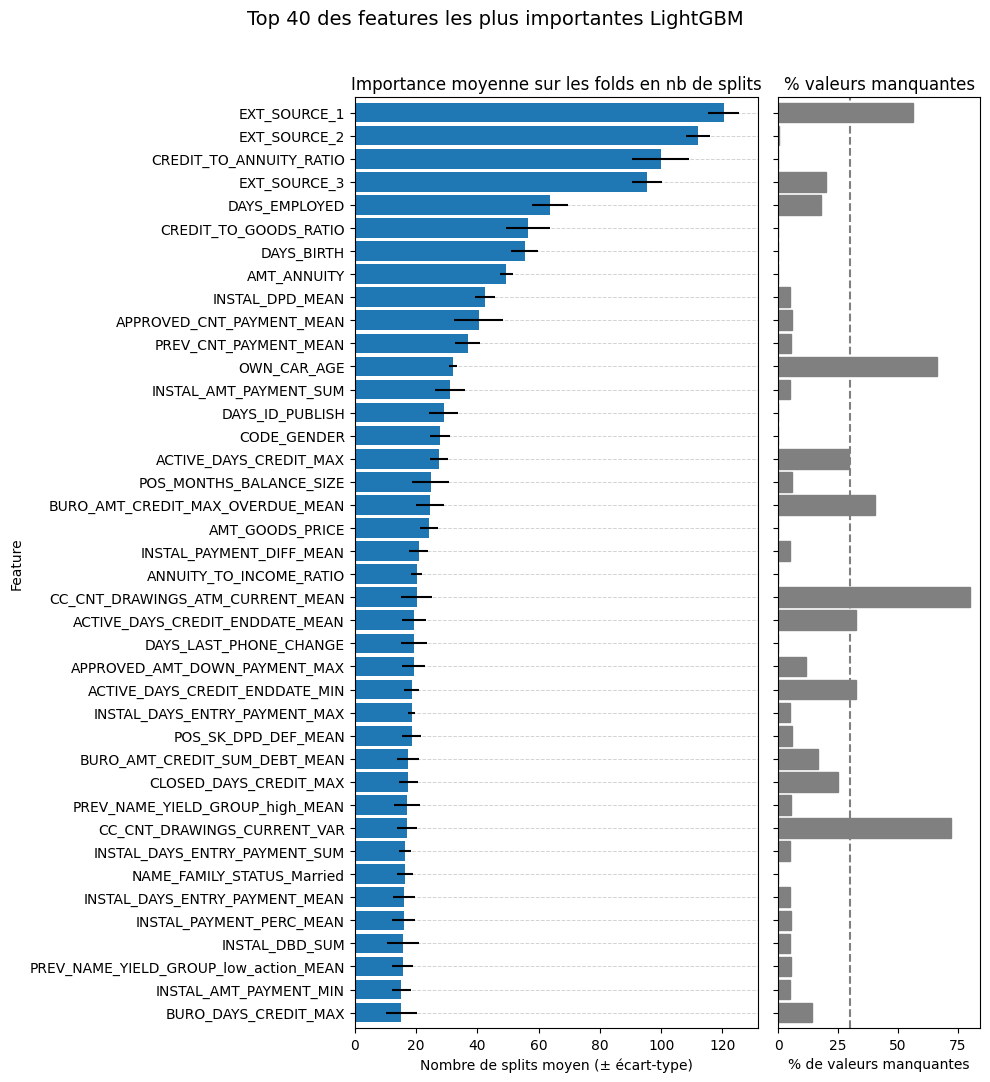

In [221]:
top40_most_important_with_missing = plot_bar_importances_with_missing(
    mean_importances, top=40
)

## Suppression des features non importantes et trop manquantes

### Sélection des features Rang >= 300 et comportant plus de 30% de valeurs manquantes

In [222]:
to_drop_rank_300 = list(
    mean_importances[
        (mean_importances["rank_importance"] >= 300)
        & (mean_importances["missing_pct"] > 30.0)
    ].index
)
print(
    f"{len(to_drop_rank_300)} features de rang d'importance >=300 et comportant plus de 30% de valeurs manquantes"
)
print(to_drop_rank_300)

143 features de rang d'importance >=300 et comportant plus de 30% de valeurs manquantes
['CC_CNT_INSTALMENT_MATURE_CUM_MEAN', 'APARTMENTS_AVG', 'COMMONAREA_MODE', 'REFUSED_AMT_CREDIT_MAX', 'REFUSED_APP_CREDIT_PERC_VAR', 'FLOORSMIN_AVG', 'REFUSED_AMT_CREDIT_MEAN', 'ACTIVE_AMT_ANNUITY_MAX', 'CC_AMT_PAYMENT_CURRENT_MEAN', 'CC_AMT_PAYMENT_CURRENT_MAX', 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'REFUSED_HOUR_APPR_PROCESS_START_MEAN', 'BURO_MONTHS_BALANCE_MIN_MIN', 'CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN', 'REFUSED_AMT_GOODS_PRICE_MIN', 'REFUSED_AMT_APPLICATION_MAX', 'ENTRANCES_MODE', 'CC_AMT_RECIVABLE_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'REFUSED_AMT_GOODS_PRICE_MAX', 'COMMONAREA_AVG', 'CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_MEAN', 'CC_AMT_BALANCE_MIN', 'CC_CNT_INSTALMENT_MATURE_CUM_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CC_AMT_DRAWINGS_POS_CURRENT_SUM', 'CC_AMT_DRAWINGS_POS_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_VAR', 'FLOORSMAX_MODE', 'CC_AMT_RECIVABLE_VAR', 'REFUSED_AMT_GOODS_

### Sauvegarde 01_V1_miss_300_train.csv

In [223]:
filepath_train = os.path.join(DATA_INTERIM, "01_v1_miss_300_train.csv")
train.drop(columns=to_drop_rank_300).to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes trop manquantes enregistré dans {filepath_train}"
)
train.drop(columns=to_drop_rank_300).info()

train après suppression des colonnes trop manquantes enregistré dans data/interim/01_v1_miss_300_train.csv
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 604 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float32(386), float64(13), int32(33), int64(14)
memory usage: 462.7 MB


In [224]:
path_features = os.path.join(DATA_INTERIM, "01_v1_miss_300_removed_features.pkl")
joblib.dump(to_drop_rank_300, path_features)
print(f"Liste des features supprimées (trop manquantes) engistrée dans {path_features}")

Liste des features supprimées (trop manquantes) engistrée dans data/interim/01_v1_miss_300_removed_features.pkl


### Sélection des features Rang >= 200 et comportant plus de 30% de valeurs manquantes

In [225]:
to_drop_rank_200 = list(
    mean_importances[
        (mean_importances["rank_importance"] >= 200)
        & (mean_importances["missing_pct"] > 30.0)
    ].index
)
print(
    f"{len(to_drop_rank_200)} features de rang d'importance >=200 et comportant plus de 30% de valeurs manquantes"
)
print(to_drop_rank_200)

192 features de rang d'importance >=200 et comportant plus de 30% de valeurs manquantes
['APARTMENTS_MODE', 'CC_CNT_DRAWINGS_CURRENT_MAX', 'BURO_STATUS_1_MEAN_MEAN', 'CLOSED_MONTHS_BALANCE_SIZE_SUM', 'LIVINGAREA_MEDI', 'REFUSED_APP_CREDIT_PERC_MEAN', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'LANDAREA_MODE', 'REFUSED_DAYS_DECISION_MIN', 'CLOSED_AMT_ANNUITY_MEAN', 'CLOSED_AMT_ANNUITY_MAX', 'REFUSED_HOUR_APPR_PROCESS_START_MIN', 'YEARS_BUILD_MODE', 'LANDAREA_AVG', 'CC_AMT_PAYMENT_CURRENT_VAR', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'BASEMENTAREA_MEDI', 'REFUSED_AMT_ANNUITY_MIN', 'BURO_AMT_ANNUITY_MEAN', 'FLOORSMAX_AVG', 'CC_AMT_INST_MIN_REGULARITY_SUM', 'CC_AMT_INST_MIN_REGULARITY_VAR', 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM', 'YEARS_BUILD_AVG', 'CC_AMT_DRAWINGS_CURRENT_VAR', 'COMMONAREA_MEDI', 'NONLIVINGAREA_AVG', 'REFUSED_AMT_APPLICATION_MIN', 'CC_AMT_DRAWINGS_CURRENT_MEAN', 'LIVINGAPARTMENTS_AVG', 'REFUSED_RATE_DOWN_PAYMENT_MAX', 'LIVINGAPARTMENTS_MODE', 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'ACTIVE_M

### Sauvegarde 01_V1_miss_200_train.csv

In [226]:
filepath_train = os.path.join(DATA_INTERIM, "01_v1_miss_200_train.csv")
train.drop(columns=to_drop_rank_200).to_csv(filepath_train, index=False)
print(
    f"train après suppression des colonnes trop manquantes enregistré dans {filepath_train}"
)
train.drop(columns=to_drop_rank_200).info()

train après suppression des colonnes trop manquantes enregistré dans data/interim/01_v1_miss_200_train.csv
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 555 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(158), float32(345), float64(12), int32(27), int64(13)
memory usage: 416.5 MB


In [227]:
path_features = os.path.join(DATA_INTERIM, "01_v1_miss_200_removed_features.pkl")
joblib.dump(to_drop_rank_200, path_features)
print(f"Liste des features supprimées (trop manquantes) engistrée dans {path_features}")

Liste des features supprimées (trop manquantes) engistrée dans data/interim/01_v1_miss_200_removed_features.pkl


# Traçage des premières expériences dans mlflow

## Objectif de cette partie

In [ ]:
"""
Pour tracer une expérience mlflow, le plus simple est de le faire "en cours de route".
C'est à dire qu'on logue les résultats au fur et à mesure qu'on les obtient au fil du code exécuté.

Toutefois, ce système peut se révéler parfois pénible, par exemple :
- On doit insérer du traçage mlflow dans du code, ce qui donne une impression de  "pas propre" et gène la généralisation.
- On a oublié de tracer l'expérience et celle-ci dure longtemps, on n'a pas envie de la recommencer juste pour tracer.

Nous allons donc explorer le traçage mlflow basique, dans deux situations :
- 1) Au fur et à mesure du code
- 2) Après coup, une fois le code terminé

Pour illustrer ces deux cas de figure, nous allons reprendre les deux sélections de features
(non importantes mais avec trop de valeurs manquantes) faites auparavant,
car celles-ci sont très simples et tès rapides à rejouer.
"""

## Démarrer l'interface web MLflow

In [ ]:
"""
Pour démarrer l'interface Web mlflow en ligne de commande, c'est très simple :
mlflow server --host 127.0.0.1 --port 5000 ou mlflow server --host localhost --port 5000

Pour lancer l'interface web, depuis le notebook, nous ouvrons un sous-processus
(celui-ci est tué dès que l'on ferme le notebook).
Comme c'est quelque chose que nous allons faire très souvent, on définit des fonctions pour cela
"""

"\nPour démarrer l'interface Web mlflow en ligne de commande, c'est très simple :\nmlflow server --host 127.0.0.1 --port 5000 ou mlflow server --host localhost --port 5000\n\nPour lancer l'interface web, depuis le notebook, nous ouvrons un sous-processus (celui-ci est tué dès que l'on ferme le notebook).\nComme c'est quelque chose que nous allons faire très souvent, on définit des fonctions pour cela\n"

In [109]:
import mlflow
import subprocess
import requests
import os
import time
from src.p7_secret import HOST_MLFLOW, PORT_MLFLOW

In [115]:
# Renvoit True si la connexion à l'interface web est ok, False sinon.
# Vérifier que l'interface web est déjà démarrée avant de lancer un sous-processus
# nous évite de lancer plein de sous-processus pour rien.
# ui = User Interface
def is_mlflow_ui_started(host=HOST_MLFLOW, port=PORT_MLFLOW, verbose=True):
    # Vérifie que le service est bien démarré
    mlflow_ui = f"http://{HOST_MLFLOW}:{PORT_MLFLOW}"
    mlflow.set_tracking_uri(mlflow_ui)
    try:
        response = requests.get(mlflow_ui)
        if response.status_code == 200:
            if verbose:
                print(f"L'interface web mlflow est disponible à l'adresse {mlflow_ui}")
            return True
    except requests.exceptions.RequestException as e:
        if verbose:
            print("La connexion MLFlow a échoué.")
            print("Error:", e)
        return False

In [112]:
is_mlflow_ui_started()

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000


True

In [113]:
# Démarre l'interface Web mlflow en ouvrant un sous-processus depuis un Notebook
# mlflow_tracking_uri="./mlruns" Les logs seront stockés dans le dossier courant, sous-dossier "mlruns"
def start_mlflow_ui(host=HOST_MLFLOW, port=PORT_MLFLOW, mlflow_tracking_uri="./mlruns"):
    # ui = User Interface (interface web de mlflow)
    mlflow_ui = f"http://{HOST_MLFLOW}:{PORT_MLFLOW}"
    if is_mlflow_ui_started(host=HOST_MLFLOW, port=PORT_MLFLOW, verbose=False):
        print(f"L'interface web mlflow est déjà disponible à l'adresse {mlflow_ui}")
        return
    else:
        # uri = Uniform Resource Identifier, chemin vers l'endroit où mlflow stocke les donnée de suivi (runs, artifacts...) sur le disque
        os.environ["MLFLOW_TRACKING_URI"] = mlflow_tracking_uri
        # Démarre MLflow UI via subprocess
        mlflow_ui_process = subprocess.Popen(
            [
                "mlflow",
                "ui",
                "--port",
                str(PORT_MLFLOW),
                "--backend-store-uri",
                mlflow_tracking_uri,
            ],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
        )

        # Donne un peu de temps au serveur pour démarrer
        time.sleep(5)
        is_mlflow_ui_started(host=HOST_MLFLOW, port=PORT_MLFLOW, verbose=True)
        return mlflow_ui_process

In [114]:
# Pour démarrer Démarrer l’interface web MLflow en ligne de commandes tout simplement :
# mlflow server --host 127.0.0.1 --port 5000
_ = start_mlflow_ui()

L'interface web mlflow est déjà disponible à l'adresse http://127.0.0.1:5000


## Traçage en cours d'éxécution avec la première expérience

### Création ou utilisation de l'expérience MLflow

In [146]:
import datetime

In [ ]:
"""
Nous allons créer une expérience ayant pour but la Feature Selection.
Ensuite, chaque expérimentation de feature sélection que nous allons faire,
sera rangée à l'intérieur de cette expérience, en tant que Un Run.
Cette organisation nous permettra de mieux nous y retrouver.
"""

In [162]:
experiment_name = "01_Feature_Selection"
experiment_description = (
    "Elimination de features (non utiles, voire nuisibles) par diverses méthodes"
)

# Si l'expérience n'xiste pas encore elle est créée, si elle existe elle est chargée
mlflow.set_experiment(experiment_name=experiment_name)

# La description d'une expérience s'indique au travers grâce à un tag particulier : 'mlflow.note.content'
experiment_tags = {
    "mlflow.note.content": experiment_description,
}
mlflow.set_experiment_tags(experiment_tags)
print(f"\nL'expérience '{experiment_name}' est maintenant active (créée ou chargée)")

# L'objet Expérience
print(
    f"\nContenu de l'objet mlflow correspondant à l'expérience (avec tous les renseignement dedans) :"
)
experiment = mlflow.get_experiment_by_name(experiment_name)
print(experiment)
print("\nL'objet peut être facilement décomposé :")
print("\tNom de l'expérience :", experiment.name)
print("\tTous les tags de l'expérience :", experiment.tags)
print("\tDescription de l'expérience :", experiment.tags["mlflow.note.content"])
print(
    f"\tID de l'expérience : {mlflow.get_experiment_by_name(experiment_name).experiment_id}"
)
# Pour les dates, on récupère un timestamp en ms,
# on le convertit en date au format désiré
dt = datetime.datetime.fromtimestamp(experiment.creation_time / 1000)
print("\tDate de création de l'expérience :", dt.strftime("%Y-%m-%d %H:%M:%S"))
print(
    f"Les résultats de l'expérience en cours seront enregistrés, par défaut, sur mon disque dur ici :"
)
print(mlflow.get_artifact_uri())
print("\tetc.")

2025/04/23 05:06:33 INFO mlflow.tracking.fluent: Experiment with name '01_Feature_Selection' does not exist. Creating a new experiment.



L'expérience '01_Feature_Selection' est maintenant active (créée ou chargée)

Contenu de l'objet mlflow correspondant à l'expérience (avec tous les renseignement dedans) :
<Experiment: artifact_location='mlflow-artifacts:/686129917202517986', creation_time=1745377593818, experiment_id='686129917202517986', last_update_time=1745377593818, lifecycle_stage='active', name='01_Feature_Selection', tags={'mlflow.note.content': 'Elimination de features (non utiles, voire nuisibles) '
                        'par diverses méthodes'}>

L'objet peut être facilement décomposé :
	Nom de l'expérience : 01_Feature_Selection
	Tous les tags de l'expérience : {'mlflow.note.content': 'Elimination de features (non utiles, voire nuisibles) par diverses méthodes'}
	Description de l'expérience : Elimination de features (non utiles, voire nuisibles) par diverses méthodes
	ID de l'expérience : 686129917202517986
	Date de création de l'expérience : 2025-04-23 05:06:33
Les résultats de l'expérience en cours ser

### Experience dans un Run

In [157]:
from src.p7_importance import importance_with_lightgbm

In [163]:
train = cudf.read_csv(os.path.join(DATA_INTERIM, "01_v0_built_train.csv"))
train = reduce_memory_cudf(train)
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = train[predictors].to_pandas()
y = train["TARGET"].to_pandas()

Memory usage of dataframe is 1086.93 MB
Memory usage after optimization is: 600.40 MB
Decreased by 44.8%


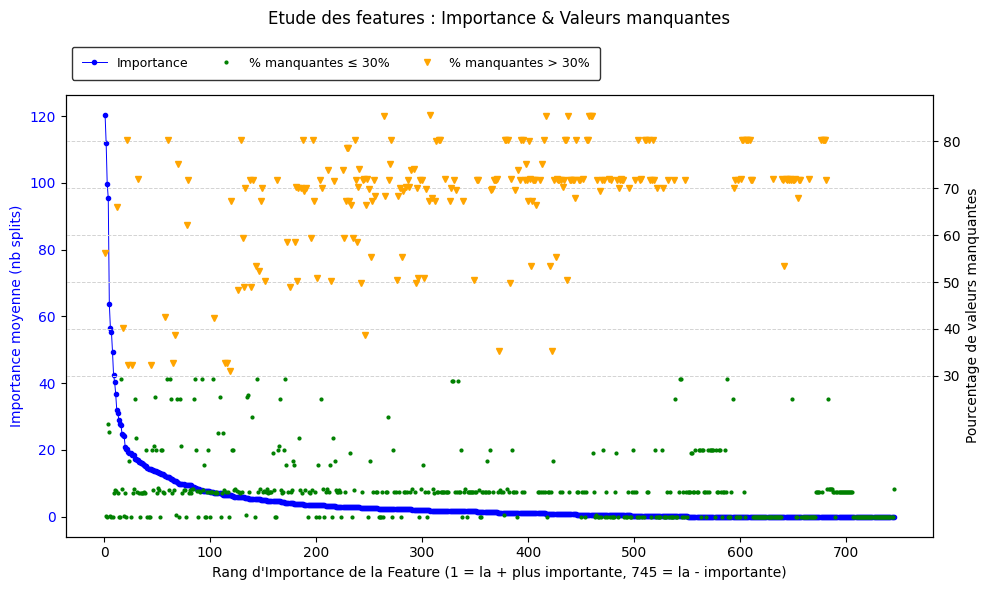

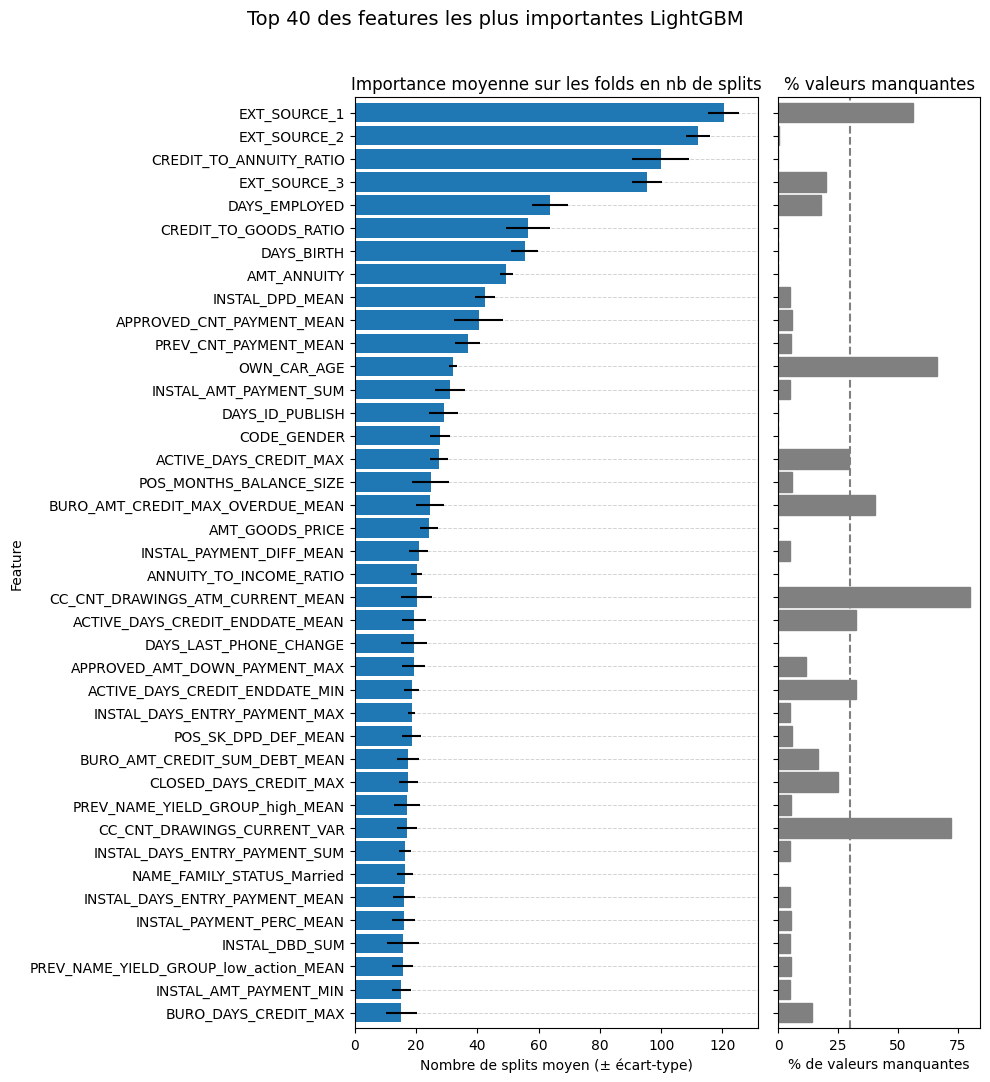

In [ ]:
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
run_name = "01_feature_importance_with_lightgbm"
run_description = "Calcul des Feature Importance en nombre de splits grâce à un modèle LightGBM en validation croisée, et pourcentage de valeurs manquantes"
run_tags = {
    "sample_size": "100%",
    "task": "feature selection",
    "step": "missing",
    "rebalancing": "class_weight",
    "model_name": "lgb",
    "api": "sklearn",
}

with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id

    # On calcule les imprtances
    importances, clf = importance_with_lightgbm(X, y)

    # On logue le dataset

    # On récupère les paramètres du modèle et on les logue
    params = clf.get_params()
    mlflow.log_params(params)

    # On trace et on logue les graphiques
    fig_line_importance_with_missing = plot_line_importance_with_missing(importances)
    filepath = os.path.join(DATA_INTERIM, "fig_line_importance_with_missing.png")
    fig_line_importance_with_missing.savefig(filepath)
    mlflow.log_artifact(filepath)

    top40_most_important_with_missing = plot_bar_importances_with_missing(
        importances, top=40
    )
    filepath = os.path.join(DATA_INTERIM, "top40_most_important_with_missing.png")
    top40_most_important_with_missing.savefig(filepath)
    mlflow.log_artifact(filepath)

mlflow.end_run()

In [ ]:
def create_or_load_experiment(
    name, description="", tags={}, artifact_location="mlflow_artifacts", verbose=True
):
    tags["mlflow.note.content"] = description

    # On vérifie si l'expérience existe déjà
    existing_experiment = mlflow.get_experiment_by_name(name)

    load_or_create = "Création de "
    if existing_experiment:
        experiment_id = existing_experiment.experiment_id
        load_or_create = "Chargement de "
    else:
        artifact_location = os.path.join(artifact_location, name)
        os.makedirs(artifact_location, exist_ok=True)
        experiment_id = mlflow.create_experiment(
            name,
            artifact_location=artifact_location,
            tags=tags,
        )
    if verbose:
        print(f"{load_or_create}l'expérience MLFlow '{name}', ID = {experiment_id}")
    return experiment_id

In [ ]:
experiment_tags = {"num_proj": "01", "task": "feature selection"}

In [53]:
experiment_id = create_or_load_experiment(
    name="debug_01", description="Eliminations de features", tags=experiment_tags
)

Création de l'expérience MLFlow 'debug_01', ID = 735915491602453003


In [65]:
experiment_name = "debug_003"
mlflow.set_experiment(experiment_name=experiment_name)
mlflow.set_experiment_tags(experiment_tags)
mlflow.get_artifact_uri()
mlflow.get_experiment_by_name(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/342116027972771721', creation_time=1745336068605, experiment_id='342116027972771721', last_update_time=1745336068605, lifecycle_stage='active', name='debug_003', tags={'mlflow.note.content': 'Eliminations de features',
 'num_proj': '01',
 'task': 'Feature selection'}>

## Création du run

In [54]:
def add_run_to_experiment(experiment_id, run_name, description="", tags={}):
    with mlflow.start_run(
        experiment_id=experiment_id,
        run_name=run_name,
        tags=tags,
        description=description,
    ) as run:
        run_id = run.info.run_id
    return run_id

In [ ]:
run_name = "drop_not_important_and_too_missing_features_01"
run_description = "Elimination des features non importantes (rang importance >=300) et comportant plus de 30% de valeurs manquantes grace à un modèle LightGBM"
run_tags = {
    "sample_size": "100%",
    "task": "feature selection",
    "step": "missing",
    "rebalancing": "class_weight",
    "model_name": "lgb",
    "api": "sklearn",
}

In [ ]:
run_id = add_run_to_experiment(experiment_id, run_name, run_description, run_tags)

'6365c1c64edf4db5a9945b2a66137252'

In [60]:
experiment_tags

{'num_proj': '01',
 'task': 'Feature selection',
 'mlflow.note.content': 'Eliminations de features'}

In [ ]:
client = MlflowClient()

# Créer ou récupérer l'expérience
if experiment_name:
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = client.create_experiment(experiment_name)
    else:
        experiment_id = experiment.experiment_id
else:
    experiment_id = client.get_experiment_by_name("Default").experiment_id

# Créer le run avec start_time
run = client.create_run(
    experiment_id=experiment_id,
    start_time=start_time,
    tags=tags if tags else {},
)
run_id = run.info.run_id

# Logger ce qu'on veut
if params:
    client.log_params(run_id, params)

if isinstance(result, dict):
    for key, value in result.items():
        if isinstance(value, (int, float)):
            client.log_metric(run_id, key, value)

if artifacts:
    for path in artifacts:
        client.log_artifact(run_id, path)

# Terminer le run avec end_time
client.set_terminated(run_id, end_time=end_time)

In [59]:
import mlflow
import time
from datetime import datetime

# Supposons que tu as déjà ton code exécuté et des métriques/paramètres/artefacts à logger

# Durée simulée
start = datetime(2025, 4, 22, 12, 0, 0)  # par exemple
end = datetime(2025, 4, 22, 12, 10, 0)  # 10 minutes plus tard

# Convertir en timestamps unix (ms)
start_time = int(start.timestamp() * 1000)
end_time = int(end.timestamp() * 1000)

# Créer ou utiliser l'expérience
mlflow.set_experiment("debug_00")

# Créer le run manuellement
client = MlflowClient()

experiment_name = "debug_00"

# Créer ou récupérer l'expérience
if experiment_name:
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = client.create_experiment(experiment_name)
    else:
        experiment_id = experiment.experiment_id
else:
    experiment_id = client.get_experiment_by_name("Default").experiment_id

# Créer le run avec start_time
run = client.create_run(
    experiment_id=experiment_id,
    start_time=start_time,
    tags=run_tags if run_tags else {},
    run_name=run_name,
)
run_id = run.info.run_id

"""# Logger ce qu'on veut
if params:
    client.log_params(run_id, params)

if isinstance(result, dict):
    for key, value in result.items():
        if isinstance(value, (int, float)):
            client.log_metric(run_id, key, value)

if artifacts:
    for path in artifacts:
        client.log_artifact(run_id, path)
"""
# Terminer le run avec end_time
client.set_terminated(run_id, end_time=end_time)

In [ ]:
if fig:
    # On sauvegarde la figure (la précédente sera écrasée, c'est volontarire)
    filepath = os.path.join(self.output_dir, "permutation.png")
    fig.savefig(filepath)
    # On loggue dans mlflow
    mlflow.log_artifact(filepath)

In [ ]:
dic_useless_features = {"useless_features": useless_features}
mlflow.log_dict(dic_useless_features, "useless_features.json")